# BERT Service Classification with FastText Embeddings

Use the Transformers library for direct interfacing with Huggingface for the full model. This allows access to all 1.8 million parameters for hypertuning and more model control. 

Reference: https://towardsdatascience.com/text-classification-with-bert-in-pytorch-887965e5820f

In [3]:
!pip3 install transformers
!pip3 install torch
!pip3 install matplotlib, tqdm, pandas

ERROR: Invalid requirement: 'matplotlib,'


Import relevant modules and libraries

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import time
import logging
import numpy as np
import pandas as pd

import torch
from torch import nn
from torch.optim import Adam
from tqdm import tqdm

from transformers import BertModel, BertTokenizer

# Data Loading

Look for the proper datafile and load it if its in the proper format

In [2]:
path = 'daily_weather_training_data_normalized.csv'

if(os.path.exists(path)):
  print('File Found:', path)
  df = pd.read_csv(path, usecols=['text', 'label'], low_memory=True, dtype=str, encoding='utf-8')
  df.head()

File Found: daily_weather_training_data_normalized.csv


Preprocess the data and ensure the dataset is balanced

<AxesSubplot:xlabel='label'>

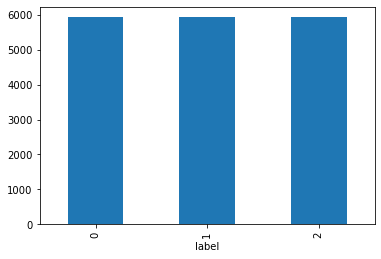

In [3]:
df['label'] = df['label'].astype(int)
df['text'] = df['text'].astype(str)

df['label'].value_counts()
df.groupby(['label']).size().plot.bar()

# Tokenization and Tensorfication

Load the tokenizer

In [4]:
tokenizer = BertTokenizer.from_pretrained("bert-base-cased")
labels = {
    0:0,
    1:1,
    2:2,
}

# labels = {
#     'positive' : 0,
#     'negative' : 1,
#     'neutral' : 2
# }

# labels = {
#     'flight-planning' : 0,
#     'ground-operations' : 1,
#     'weather' : 2,
#     'emergency' : 3,
#     'communication' : 4

# }

Create the numpy dataset

In [5]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):

        self.labels = [labels[label] for label in df['label']]
        self.texts = [tokenizer(text, 
                               padding='max_length', max_length = 512, truncation=True,
                                return_tensors="pt") for text in df['text']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

Set the training and evaluation dataframes and convert the numpy features

In [6]:
np.random.seed(112)
df_train, df_val, df_test = np.split(df.sample(frac=1, random_state=42), 
                                     [int(.8*len(df)), int(.9*len(df))])

print(len(df_train),len(df_val), len(df_test))

14212 1777 1777


# Model Building

In [2]:
class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 5)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer

# Training

Set up the training loops

In [21]:
def train(model, train_data, val_data, learning_rate, epochs):

    train, val = Dataset(train_data), Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr= learning_rate)

    if use_cuda:

            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader):

                train_label = train_label.type(torch.LongTensor)
                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)
                
                batch_loss = criterion(output, train_label)
                total_loss_train += batch_loss.item()
                
                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            
            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label)
                    total_loss_val += batch_loss.item()
                    
                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc
            
            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} \
                | Train Accuracy: {total_acc_train / len(train_data): .3f} \
                | Val Loss: {total_loss_val / len(val_data): .3f} \
                | Val Accuracy: {total_acc_val / len(val_data): .3f}'
            )

Train the model

In [ ]:
EPOCHS = 15
model = BertClassifier()
LR = 3e+5
              
train(model, df_train, df_val, LR, EPOCHS)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
  0%|                                                                                                                                                        

In [ ]:
torch.save(model, "service_classifier_model.pkl")
torch.save(tokenizer, "service_classifier_model_tokenizer.pkl")

# Evaluate the Model

In [11]:
def evaluate(model, test_data):

    test = Dataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=5)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:
        model = model.cuda()

    total_acc_test = 0
    with torch.no_grad():

        for test_input, test_label in test_dataloader:

              test_label = test_label.to(device)
              mask = test_input['attention_mask'].to(device)
              input_id = test_input['input_ids'].squeeze(1).to(device)

              output = model(input_id, mask)

              acc = (output.argmax(dim=1) == test_label).sum().item()
              total_acc_test += acc
              print(output.argmax(dim=1))
    
    print(f'Test Accuracy: {total_acc_test / len(test_data)*100: .3f}%')
    
evaluate(model, df_test)

tensor([2], device='cuda:0')
Test Accuracy:  0.000%


 # Model Prediction

In [3]:
def predict(model, tokenizer, sentence):
    encoded = tokenizer.encode_plus(
        sentence,
        add_special_tokens=True,
        return_token_type_ids=False,
        padding=True,
        return_attention_mask=True,
        return_tensors='pt',
    )

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:
        model = model.cuda()

    input_ids = encoded['input_ids'].to(device)
    attention_mask = encoded['attention_mask'].to(device)

    output = model(input_ids, attention_mask)
    _, prediction = torch.max(output, dim=1)

    label_converts = {
        0 : 'Negative',
        1 : 'Positive',
        2 : 'Neutral'
    }

    return label_converts[prediction.argmax(dim=0).sum().item()]

In [10]:
import torch
from transformers import BertTokenizer, BertModel

bertclassifiermodel = torch.load("/Users/Kamran/Documents/GitHub/bert-model-eval/outputs/model.pkl")
sentence = input("Enter your sentence: ")
print("Sentiment: ", predict(bertclassifiermodel, BertTokenizer.from_pretrained("bert-base-cased"), sentence))

Sentiment:  Negative


In [5]:
!python -V

Python 3.9.7
